# Comparative Analysis Against the Constituent Models

## Evaluate Ensemble Model

In [2]:
import os
from pathlib import Path


Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_constituent_models').mkdir(parents=True, exist_ok=True)

os.system(
    'cd ' + os.environ['EHR_ML_BASE'] + ';'
    +
    '''.venv/bin/python -m ehrml.ensemble.Evaluate ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/final/data_matrix.csv -tc "death_adm" -ic "person_id" "visit_occurrence_id" -mdc "measurement_date" -adc "visit_start_date_adm" -wb ''' + str(600) + ''' -wa ''' + str(600) + ''' -sp ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/benchmarking/04_constituent_models/ensemble_scores.json'''
)

2024-06-19 15:17:54,891 - EHR-ML - INFO - Parsing command line arguments
2024-06-19 15:17:54,892 - EHR-ML - INFO - args.data_file: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/final/data_matrix.csv
2024-06-19 15:17:54,893 - EHR-ML - INFO - args.target_column: death_adm
2024-06-19 15:17:54,893 - EHR-ML - INFO - args.id_columns: ['person_id', 'visit_occurrence_id']
2024-06-19 15:17:54,893 - EHR-ML - INFO - args.measurement_date_column: measurement_date
2024-06-19 15:17:54,893 - EHR-ML - INFO - args.anchor_date_column: visit_start_date_adm
2024-06-19 15:17:54,893 - EHR-ML - INFO - args.window_before: 600
2024-06-19 15:17:54,893 - EHR-ML - INFO - args.window_after: 600
2024-06-19 15:17:54,893 - EHR-ML - INFO - args.save_path: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/benchmarking/04_constituent_models/ensemble_scores.json
2024-06-19 15:17:54,893 - EHR-ML - INFO - Reading data from file: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/final

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 4: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:

0

## Prepare data for Internal Constituent Models

In [1]:
import os
import sys


sys.path.append(os.environ['EHR_ML_BASE'])

from ehrml.utils import DataUtils


X, XVitalsAvg, XVitalsMin, XVitalsMax, XVitalsFirst, XVitalsLast, XLabsAvg, XLabsMin, XLabsMax, XLabsFirst, XLabsLast, y, idsDf = DataUtils.readData(
        dirPath = os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/final/data_matrix.csv''',
        idColumns=["person_id", "visit_occurrence_id"],
        targetColumn='death_adm',
        anchorDateColumn='visit_start_date_adm',
        measurementDateColumn='measurement_date',
        windowStart=600,
        windowEnd=600
    )

## A Function to Calculate MCC-F1 Score

In [2]:
def calculateMccF1(x, y):
    import sys
    import os

    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr

    # import R's "base" package
    mccf1 = importr('mccf1')

    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    p = robjects.FloatVector(x)
    t = robjects.FloatVector(y)
    calculateMccf1 = robjects.r['mccf1']
    summary = robjects.r['summary']
    out = summary(calculateMccf1(t, p), 50)[0][0]
    sys.stdout = old_stdout # reset old stdout
    return out

## Constituent XGB Model

In [3]:
def getBestXgbHyperparameter(X, y, tuned_params, parameters):

    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    params = {}

    print('Hyperparameter optimisation for: ' + str(parameters))

    clf = GridSearchCV(XGBClassifier(use_label_encoder=False, **tuned_params), parameters)
    clf.fit(X, y)

    params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

    return(params)


def performXgbHyperparameterTuning(X, y):

    params = {}

    params.update(getBestXgbHyperparameter(X, y, params, {'max_depth' : range(1,10),'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],}))

    params.update(getBestXgbHyperparameter(X, y, params, {'n_estimators':range(50,250,10)}))

    params.update(getBestXgbHyperparameter(X, y, params, {'min_child_weight':range(1,10)}))

    params.update(getBestXgbHyperparameter(X, y, params, {'gamma':[i/10. for i in range(0,5)]}))

    params.update(getBestXgbHyperparameter(X, y, params, {'subsample':[i/10.0 for i in range(1,10)],'colsample_bytree':[i/10.0 for i in range(1,10)]}))

    params.update(getBestXgbHyperparameter(X, y, params, {'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]}))

    print('params: ' + str(params))

    return params


def buildXGBoostModel(X, y):
    print('Performing Hyperparameter optimisation')

    from sklearn.metrics import make_scorer

    from xgboost import XGBClassifier

    print('Building the model')
    
    params = performXgbHyperparameterTuning(X, y)

    xgb = XGBClassifier(use_label_encoder=False)
    xgb.set_params(**params)

    print('Performing cross-validation')

    from sklearn.model_selection import cross_validate

    xgbScores = cross_validate(xgb, X, y, cv=5, scoring=['accuracy', 'balanced_accuracy',  'average_precision', 'f1', 'roc_auc'])
    xgbScores['test_mccf1_score'] = cross_validate(xgb, X, y, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']

    return xgbScores

## Constituent LR Model

In [4]:
def buildLRModel(X, y):
    print('Performing Hyperparameter optimisation')

    from sklearn.metrics import make_scorer

    from sklearn.linear_model import LogisticRegression

    from sklearn.model_selection import GridSearchCV

    parameters={
        'solver': ['newton-cg', 'liblinear'],
        'C': [100, 10, 1.0, 0.1, 0.01],
    }

    clf = GridSearchCV(LogisticRegression(), parameters)
    clf.fit(X, y)

    params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

    print('Building the model')

    lr = LogisticRegression()
    lr.set_params(**params)

    print('Performing cross-validation')

    from sklearn.model_selection import cross_validate

    lrScores = cross_validate(lr, X, y, cv=5, scoring=['accuracy', 'balanced_accuracy',  'average_precision', 'f1', 'roc_auc'])
    lrScores['test_mccf1_score'] = cross_validate(lr, X, y, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']

    return lrScores

## Constituent LGBM Model

In [5]:
def getBestLgbmHyperparameter(X, y, tuned_params, parameters):

    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    params = {}

    print('Hyperparameter optimisation for: ' + str(parameters))

    clf = GridSearchCV(XGBClassifier(use_label_encoder=False, **tuned_params), parameters)
    clf.fit(X, y)

    params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

    return(params)


def performLgbmHyperparameterTuning(X, y):

    params = {}

    params.update(getBestLgbmHyperparameter(X, y, params, {'max_depth' : range(1,10),'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],}))

    params.update(getBestLgbmHyperparameter(X, y, params, {'n_estimators':range(50,250,10)}))

    params.update(getBestLgbmHyperparameter(X, y, params, {'min_child_weight':range(1,10)}))

    params.update(getBestLgbmHyperparameter(X, y, params, {'gamma':[i/10. for i in range(0,5)]}))

    params.update(getBestLgbmHyperparameter(X, y, params, {'subsample':[i/10.0 for i in range(1,10)],'colsample_bytree':[i/10.0 for i in range(1,10)]}))

    params.update(getBestLgbmHyperparameter(X, y, params, {'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]}))

    print('params: ' + str(params))

    return params


def buildLgbmModel(X, y):
    print('Performing Hyperparameter optimisation')

    from sklearn.metrics import make_scorer

    from lightgbm import LGBMClassifier

    print('Building the model')
    
    params = performLgbmHyperparameterTuning(X, y)

    lgbm = LGBMClassifier(use_label_encoder=False)
    lgbm.set_params(**params)

    print('Performing cross-validation')

    from sklearn.model_selection import cross_validate

    lgbmScores = cross_validate(lgbm, X, y, cv=5, scoring=['accuracy', 'balanced_accuracy',  'average_precision', 'f1', 'roc_auc'])
    lgbmScores['test_mccf1_score'] = cross_validate(lgbm, X, y, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']

    return lgbmScores

## Constituent MLP Model

In [6]:
def buildMLPModel(X, y, layerSize):

    print('Building the model')

    from sklearn.metrics import make_scorer

    from sklearn.neural_network import MLPClassifier

    mlp = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes = (layerSize, layerSize))
    mlp.fit(X, y)

    print('Performing cross-validation')

    from sklearn.model_selection import cross_validate

    mlpScores = cross_validate(mlp, X, y, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
    mlpScores['test_mccf1_score'] = cross_validate(mlp, X, y, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
    return mlpScores

## Function to save the results

In [7]:
def saveResults(scores, savePath):
    import json

    for key, value in scores.items():
        scores[key] = value.tolist()

    with open(savePath, 'w') as fp:
        json.dump(scores, fp, indent=4)

## Create data dictionary

In [14]:
dataDict = {
    'vitals_avg': XVitalsAvg,
    'vitals_min': XVitalsMin,
    'vitals_max': XVitalsMax,
    'vitals_first': XVitalsFirst,
    'vitals_last': XVitalsLast,
    'labs_avg': XLabsAvg,
    'labs_min': XLabsMin,
    'labs_max': XLabsMax,
    'labs_first': XLabsFirst,
    'labs_last': XLabsLast,
}

## Evaluate Constituent Models

In [15]:
import os

from pathlib import Path


dirPath = Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_constituent_models/')
dirPath.mkdir(parents=True, exist_ok=True)

for label, dataDf in dataDict.items():
    xgbScores = buildXGBoostModel(X=XVitalsAvg, y=y.values.ravel())
    xgbScoresFilePath = Path(dirPath, 'xgb_' + label + '_scores.json')
    saveResults(xgbScores, xgbScoresFilePath)
    lrScores = buildLRModel(X=XVitalsAvg, y=y.values.ravel())
    lrScoresFilePath = Path(dirPath, 'lr_' + label + '_scores.json')
    saveResults(lrScores, lrScoresFilePath)
    lgbmScores = buildLgbmModel(X=XVitalsAvg, y=y.values.ravel())
    lgbmScoresFilePath = Path(dirPath, 'lgbm_' + label + '_scores.json')
    saveResults(lgbmScores, lgbmScoresFilePath)
    mlpScores = buildMLPModel(X=XVitalsAvg, y=y.values.ravel(), layerSize=50)
    mlpScoresFilePath = Path(dirPath, 'mlp_' + label + '_scores.json')
    saveResults(mlpScores, mlpScoresFilePath)

Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
Performing Hyperparameter optimisation


/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Building the model
Performing cross-validation
Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0}
Performing cross-validation
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown pa

## Function to read scores

In [1]:
def readScores(filePath):
    import json

    with open(filePath) as f:
        scores = json.load(f)

    return(scores)

## Plot

In [2]:
import os
from pathlib import Path

import pandas as pd


data = []

dirPath = Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_constituent_models/')
for file in os.listdir(dirPath):
    if(file.endswith('.json') & (file != 'ensemble_scores.json')):
        # print(file.split('.')[0].split('_')[0], file.split('.')[0].split('_')[1] + '_' + file.split('.')[0].split('_')[2], file)
        scores = readScores(Path(dirPath, file))
        metricsDict = {'model': file.split('.')[0].split('_')[0], 'data_set': file.split('.')[0].split('_')[1] + '_' + file.split('.')[0].split('_')[2]}
        for key, value in scores.items():
            metricsDict[key] = sum(value)/len(value)
        data.append(metricsDict)
scoresDf = pd.DataFrame(data)
scoresDf

,model,data_set,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_average_precision,test_f1,test_roc_auc,test_mccf1_score
0,xgb,labs_first,0.086663,0.012527,0.883456,0.524524,0.295496,0.096911,0.686158,0.295321
1,lr,vitals_avg,0.025861,0.008584,0.882110,0.512993,0.278808,0.053586,0.694310,0.259063
2,lgbm,vitals_first,0.060259,0.012297,0.881572,0.511058,0.308999,0.046677,0.702227,0.254270
3,lgbm,labs_first,0.065357,0.012188,0.881572,0.511058,0.308999,0.046677,0.702227,0.254270
4,lgbm,vitals_last,0.061064,0.012025,0.881572,0.511058,0.308999,0.046677,0.702227,0.254270
5,xgb,labs_last,0.085326,0.012394,0.883456,0.524524,0.295496,0.096911,0.686158,0.295321
6,xgb,vitals_avg,0.085856,0.011701,0.883456,0.524524,0.295496,0.096911,0.686158,0.295321
7,lr,vitals_first,0.026102,0.008830,0.882110,0.512993,0.278808,0.053586,0.694310,0.259063
8,mlp,labs_first,1.208757,0.013324,0.880226,0.530151,0.285680,0.109691,0.692322,0.298464
9,xgb,labs_max,0.091667,0.012013,0.883456,0.524524,0.295496,0.096911,0.686158,0.295321


In [3]:
bestConstituentScoresDf = scoresDf[['model', 'test_accuracy', 'test_roc_auc', 'test_balanced_accuracy', 'test_average_precision', 'test_mccf1_score', 'test_f1']]\
    .groupby('model').agg(max).reset_index()
bestConstituentScoresDf

,model,test_accuracy,test_roc_auc,test_balanced_accuracy,test_average_precision,test_mccf1_score,test_f1
0,lgbm,0.881572,0.702227,0.511058,0.308999,0.254270,0.046677
1,lr,0.882110,0.694310,0.512993,0.278808,0.259063,0.053586
2,mlp,0.880226,0.692322,0.530151,0.285680,0.298464,0.109691
3,xgb,0.883456,0.686158,0.524524,0.295496,0.295321,0.096911


In [4]:
data = []

dirPath = Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_constituent_models/')
file = 'ensemble_scores.json'
scores = readScores(Path(dirPath, file))
metricsDict = {'model': 'ensemble'}
for key, value in scores.items():
    metricsDict[key] = sum(value)/len(value)
data.append(metricsDict)
ensembleScoresDf = pd.DataFrame(data)
ensembleScoresDf = ensembleScoresDf[['model', 'test_accuracy', 'test_roc_auc', 'test_balanced_accuracy', 'test_average_precision', 'test_mccf1_score', 'test_f1']]
ensembleScoresDf

,model,test_accuracy,test_roc_auc,test_balanced_accuracy,test_average_precision,test_mccf1_score,test_f1
0,ensemble,0.903823,0.859436,0.69228,0.539848,0.601242,0.503185


In [9]:
import pandas as pd


plotScoresDf = pd.concat([bestConstituentScoresDf, ensembleScoresDf], ignore_index=True)
plotScoresDf.columns = ['model', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'mccf1_score', 'f1']
plotScoresDf

,model,accuracy,roc_auc,balanced_accuracy,average_precision,mccf1_score,f1
0,lgbm,0.881572,0.702227,0.511058,0.308999,0.254270,0.046677
1,lr,0.882110,0.694310,0.512993,0.278808,0.259063,0.053586
2,mlp,0.880226,0.692322,0.530151,0.285680,0.298464,0.109691
3,xgb,0.883456,0.686158,0.524524,0.295496,0.295321,0.096911
4,ensemble,0.903823,0.859436,0.692280,0.539848,0.601242,0.503185


In [6]:
plot_colors = ['#FF1F5B', '#00CD6C', '#009ADE', '#AF58BA', '#FFC61E']
labels_to_display = ['LGBM (Best value)', 'LR (Best value)', 'MLP (Best value)', 'XGB (Best value)', 'XGB Ensemble']
# labels = ['xgb', 'lr', 'lgbm', 'mlp', 'XGBensemble']

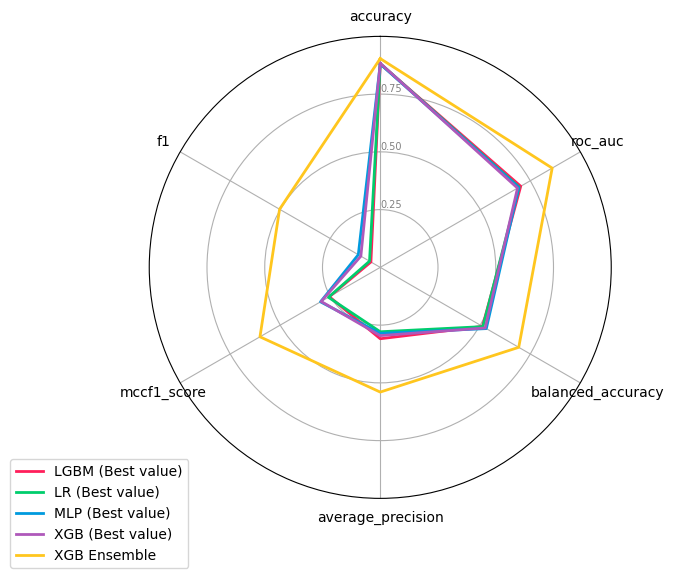

In [10]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Set data
df = pd.DataFrame(plotScoresDf)

# ------- PART 1: Create background

# number of variable
categories=list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
# ax.figsize(10, 10)
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.50","0.75"], color="grey", size=7)
plt.ylim(0,1)


# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable

for i in [0, 1, 2, 3, 4]:
    # Ind1
    values=df.loc[i].drop('model').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels_to_display[i], color=plot_colors[i])
    # ax.fill(angles, values, 'b', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()
